In [15]:
from typing import Callable, Any, Set, Tuple, List, FrozenSet, Dict
from functools import lru_cache
from sentence_transformers import SentenceTransformer, util
import numpy as np
import statistics

# --- SBERT Helpers ---
sbert_model = SentenceTransformer("all-MiniLM-L6-v2")
_seen_debugs = {level: set() for level in ["literal", "clause", "formula"]}
_debug_summary = {level: [] for level in ["literal", "clause", "formula"]}

@lru_cache(maxsize=2048)
def get_embedding(text: str):
    return sbert_model.encode(text, convert_to_tensor=True)

def normalize_str(s: str) -> str:
    return s.lower().replace("_", " ").replace("(", "").replace(")", "").replace("not ", "¬").strip()

def sim_sbert_normalized(a: str, b: str) -> float:
    a_norm, b_norm = normalize_str(a), normalize_str(b)
    return util.cos_sim(get_embedding(a_norm), get_embedding(b_norm)).item()

def agg_max(scores: List[float]) -> float:
    return max(scores) if scores else 0.0

def agg_avg(scores: List[float]) -> float:
    return sum(scores) / len(scores) if scores else 0.0

def agg_softmax(scores: List[float], temperature: float = 2.5) -> float:
    if not scores:
        return 0.0
    exp_scores = [np.exp(s * temperature) for s in scores]
    softmax_weights = [e / sum(exp_scores) for e in exp_scores]
    return sum(w * s for w, s in zip(softmax_weights, scores))

def pointwise_similarity_weighted(
    args1: List[str],
    args2: List[str],
    simC: Callable[[str, str], float],
    weights1: Dict[str, float],
    weights2: Dict[str, float],
    positional_weight: float = 0.75,
    unordered_penalty: float = 0.25,
    diff: float = 0
) -> float:
    if not args1 or not args2:
        return 0.0

    # Partie ordonnée
    min_len = min(len(args1), len(args2))
    sim_pos, total_weight_pos = 0.0, 0.0
    for i in range(min_len):
        a1, a2 = args1[i], args2[i]
        sim = simC(a1, a2)
        w1 = weights1.get(a1, 0.0)
        w2 = weights2.get(a2, 0.0)
        importance = w1 * w2
        sim_pos += importance * sim
        total_weight_pos += importance
    sim_pos = sim_pos / total_weight_pos if (diff == 0 and total_weight_pos > 0) else sim_pos

    # Partie non ordonnée
    sim_unordered, total_weight_unordered = 0.0, 0.0
    for a1 in args1:
        w1 = weights1.get(a1, 0.0)
        best = 0.0
        for a2 in args2:
            w2 = weights2.get(a2, 0.0)
            sim = simC(a1, a2)
            importance = w1 * w2
            best = max(best, sim * importance)
        sim_unordered += best
        total_weight_unordered += w1
    sim_unordered = sim_unordered / total_weight_unordered if (diff == 0 and total_weight_unordered > 0) else sim_unordered

    return positional_weight * sim_pos + (1 - positional_weight) * unordered_penalty * sim_unordered


def simLiteral(
    obj1: Tuple[str, Tuple[str, ...]],
    obj2: Tuple[str, Tuple[str, ...]],
    predicate_weights: Dict[str, float],
    constant_weights: Dict[str, float],
    debug: dict = None,
    diff: float = 0.0
) -> float:
    pred1, args1 = obj1
    pred2, args2 = obj2

    sim_pred = sim_sbert_normalized(pred1, pred2)
    imp_pred = predicate_weights.get(pred1, 0.0) * predicate_weights.get(pred2, 0.0)
    num = sim_pred * imp_pred
    denom = imp_pred

    sim_args = pointwise_similarity_weighted(
        list(args1), list(args2), sim_sbert_normalized,
        weights1=constant_weights,
        weights2=constant_weights,
        diff=diff
    )

    imp_args_total = sum(
        constant_weights.get(a1, 0.0) * constant_weights.get(a2, 0.0)
        for a1 in args1 for a2 in args2
    )
    num += sim_args * imp_args_total
    denom += imp_args_total

    if diff > 0:
        denom = 1

    score = num / denom if denom > 0 else 0.0

    if debug and debug.get("literal", False):
        key = frozenset({obj1, obj2})
        if key not in _seen_debugs["literal"]:
            _seen_debugs["literal"].add(key)
            _debug_summary["literal"].append((obj1, obj2, sim_pred, sim_args, score))
    return score


def generalized_tversky_similarity(
    X: Set[Any],
    Y: Set[Any],
    sim: Callable[[Any, Any], float],
    alpha: float = 1.0,
    beta: float = 1.0,
    p: float = 1.0,
    agg: Callable[[List[float]], float] = max,
    debug: dict = None,
    debug_level: str = ""
) -> float:
    if not X or not Y:
        return 0.0

    def membership(x, Y):
        return agg([sim(x, y) ** p for y in Y])

    match_X = [membership(x, Y) for x in X]
    match_Y = [membership(y, X) for y in Y]

    a = (sum(match_X) + sum(match_Y)) / 2
    b = sum(1 - s for s in match_X)
    c = sum(1 - s for s in match_Y)

    denom = a + alpha * b + beta * c
    score = a / denom if denom > 0 else 0.0

    if debug and debug.get(debug_level, False):
        _debug_summary[debug_level].append(("TOTAL", a, b, c, score))

        if debug_level == "literal":
            pass  # already logged

        elif debug_level == "clause":
            for x in X:
                for y in Y:
                    s = sim(x, y)
                    _debug_summary[debug_level].append(("clause_pair", x, y, s))

        elif debug_level == "formula":
            for x in X:
                for y in Y:
                    _debug_summary[debug_level].append(("formula_pair", x, y, score))

    return score

def simFormulaSet(
    F1: Set[FrozenSet[Tuple[str, Tuple[str, ...]]]],
    F2: Set[FrozenSet[Tuple[str, Tuple[str, ...]]]],
    predicate_weights1: Dict[str, float],
    predicate_weights2: Dict[str, float],
    constant_weights1: Dict[str, float],
    constant_weights2: Dict[str, float],
    params: dict = None,
    debug: dict = None
) -> Tuple[float, Dict[str, List[Any]]]:
    for level in _seen_debugs:
        _seen_debugs[level].clear()
    for level in _debug_summary:
        _debug_summary[level].clear()

    # Merge predicate and constant weights
    predicate_weights = {**predicate_weights1, **predicate_weights2}
    constant_weights = {**constant_weights1, **constant_weights2}

    sum_preds = sum(v1 for p,v1 in predicate_weights1.items()) + sum(v2 for p,v2 in predicate_weights2.items())
    sum_consts = sum(v1 for c,v1 in constant_weights1.items()) + sum(v2 for c,v2 in constant_weights2.items())
    diff = 2 - sum_preds - sum_consts
    epsilon = 1e-4  # seuil de tolérance
    diff = 0.0 if abs(diff) < epsilon else diff
    print(diff)

    alpha = params.get("formula", {}).get("alpha", 1.0)
    beta = params.get("formula", {}).get("beta", 1.0)
    p = params.get("formula", {}).get("p", 1.0)
    agg = params.get("formula", {}).get("agg", max)

    score = generalized_tversky_similarity(
        F1, F2,
        sim=lambda c1, c2: generalized_tversky_similarity(
            c1, c2,
            sim=lambda l1, l2: simLiteral(l1, l2, predicate_weights, constant_weights, debug=debug, diff=diff),
            alpha=params.get("clause", {}).get("alpha", 0.5),
            beta=params.get("clause", {}).get("beta", 0.5),
            p=params.get("clause", {}).get("p", 1.0),
            agg=params.get("clause", {}).get("agg", max),
            debug=debug,
            debug_level="clause"
        ),
        alpha=alpha,
        beta=beta,
        p=p,
        agg=agg,
        debug=debug,
        debug_level="formula"
    )
    return score, _debug_summary


In [16]:
def summarize_debug_output(summary: dict, debug: dict = None, top_n: int = 10):
    print("\n🔍 SUMMARY OF SIMILARITY COMPARISON\n")

    if debug.get("literal", False):
        print("📌 LITERAL LEVEL")
        literals = summary.get("literal", [])
        print(f"  → Total literal pairs compared: {len(literals)}")
        for (lit1, lit2, sim_pred, sim_args, score) in literals:
            print(f"    - {lit1} ⇄ {lit2}")
            print(f"      • predicate similarity: {sim_pred}")
            print(f"      • argument similarity : {sim_args}")
            print(f"      • literal similarity   : {score:.3f}")

    if debug.get("clause", False):
        print("\n📌 CLAUSE LEVEL")
        clauses = summary.get("clause", [])
        detailed = [e for e in clauses if isinstance(e, tuple) and len(e) == 4 and e[0] == "clause_pair"]
        print(f"  → Total clause pairs compared: {len(detailed)}")
        for (_, clause1, clause2, score) in detailed:
            print(f"    - Clause 1: {clause1}")
            print(f"      Clause 2: {clause2}")
            print(f"      → Similarity score: {score:.3f}")

    if debug.get("formula", False):
        print("\n📌 FORMULA LEVEL")
        formulas = summary.get("formula", [])
        totals = [e for e in formulas if isinstance(e, tuple) and e[0] == "TOTAL"]
        details = [e for e in formulas if isinstance(e, tuple) and e[0] == "formula_pair"]
        for (_, a, b, c, score) in totals:
            print("  → Overall formula similarity:")
            print(f"      a = matched        : {a:.3f}")
            print(f"      b = unmatched src  : {b:.3f}")
            print(f"      c = unmatched tgt  : {c:.3f}")
            print(f"      → Similarity score : {score:.3f}")
        for (_, f1, f2, score) in details:
            print("  → Formula pair compared:")
            print(f"      Formula 1: {f1}")
            print(f"      Formula 2: {f2}")
            print(f"      → Similarity score: {score:.3f}")


In [17]:
import numpy as np
import statistics
import pandas as pd
import matplotlib.pyplot as plt

def summarize_debug_statistics(summary):
    print("\n🔍 STATISTICAL SUMMARY PER LEVEL")
    for level, entries in summary.items():
        if not entries:
            continue
        try:
            sims = [entry[-1] for entry in entries if isinstance(entry[-1], float)]
        except Exception as e:
            print(f"  ⚠️ Error extracting scores from level {level}: {e}")
            continue

        print(f"\n📎 Level: {level.upper()}")
        print(f"  - Count: {len(sims)}")
        print(f"  - Min: {min(sims):.3f}")
        print(f"  - Max: {max(sims):.3f}")
        print(f"  - Mean: {statistics.mean(sims):.3f}")
        print(f"  - Stdev: {statistics.stdev(sims):.3f}" if len(sims) > 1 else "  - Stdev: N/A")
        low = [s for s in sims if s < 0.3]
        print(f"  - < 0.3: {len(low)} cases ({len(low)/len(sims)*100:.1f}%)")


def plot_similarity_distribution(summary):
    data = []
    ordered_levels = ["literal", "clause", "formula"]

    for level in ordered_levels:
        entries = summary.get(level, [])
        if not entries:
            continue

        def get_score(entry):
            if isinstance(entry[-1], float):
                return entry[-1]
            elif isinstance(entry, tuple) and len(entry) >= 2 and isinstance(entry[1], float):
                return entry[1]
            return None

        scores = [get_score(e) for e in entries]
        scores = [s for s in scores if s is not None]
        data.extend([(level, s) for s in scores])

    if not data:
        print("No similarity data to plot.")
        return

    df = pd.DataFrame(data, columns=["level", "similarity"])

    plt.figure(figsize=(12, 6))

    ax1 = plt.subplot(1, 2, 1)
    df["level"] = pd.Categorical(df["level"], categories=ordered_levels, ordered=True)
    df.boxplot(by="level", column="similarity", grid=False, ax=ax1)
    ax1.set_ylim(0, 1)
    ax1.set_title("Similarity Distribution per Level (Boxplot)")
    ax1.set_xlabel("Level")
    ax1.set_ylabel("Similarity")
    plt.suptitle("")

    ax2 = plt.subplot(1, 2, 2)
    for level in ordered_levels:
        group = df[df["level"] == level]
        if not group.empty:
            group["similarity"].plot(kind="hist", alpha=0.6, bins=10, label=level, ax=ax2)
    ax2.set_title("Similarity Score Histograms per Level")
    ax2.set_xlabel("Similarity")
    ax2.set_xlim(0, 1)
    ax2.legend()

    plt.tight_layout()
    plt.show()


def summarize_explanation(summary, params):
    print("\n📋 EXPLANATION SUMMARY BY LEVEL")
    for level, entries in summary.items():
        print(f"\n🔹 Level: {level.upper()}")
        if not entries:
            print("  (No entries)")
            continue

        # Fonction robuste d'extraction du score
        def get_score(entry):
            if isinstance(entry[-1], float):
                return entry[-1]
            elif isinstance(entry, tuple) and len(entry) >= 2 and isinstance(entry[1], float):
                return entry[1]
            return 0.0

        entries_sorted = sorted(entries, key=get_score, reverse=True)

        seen = set()

        def printable(e):
            return str(e)

        top5 = []
        for entry in entries_sorted:
            rep = printable(entry)
            if rep not in seen:
                top5.append(entry)
                seen.add(rep)
            if len(top5) == 5:
                break

        high_scores = []
        for entry in entries_sorted:
            score = get_score(entry)
            rep = printable(entry)
            if score > 0.8 and rep not in seen:
                high_scores.append(entry)
                seen.add(rep)

        for entry in top5:
            print(f"  ⭐ Top: {entry}")
        for entry in high_scores:
            print(f"  ✅ High (>0.8): {entry}")



0.0

🔷 FINAL SIMILARITY SCORE: 0.604

🔍 SUMMARY OF SIMILARITY COMPARISON

📌 LITERAL LEVEL
  → Total literal pairs compared: 8
    - ('AtLocation', ('Dog', 'Zoo')) ⇄ ('AtLocation', ('Dog', 'Zoo'))
      • predicate similarity: 0.9999999403953552
      • argument similarity : 0.7604166847964127
      • literal similarity   : 0.834
    - ('AtLocation', ('Dog', 'Zoo')) ⇄ ('Teasing', ('Monkey', 'Dog'))
      • predicate similarity: 0.1458677053451538
      • argument similarity : 0.33377294838428495
      • literal similarity   : 0.271
    - ('AtLocation', ('Dog', 'Zoo')) ⇄ ('AtLocation', ('Monkey', 'Zoo'))
      • predicate similarity: 0.9999999403953552
      • argument similarity : 0.43563099056482313
      • literal similarity   : 0.609
    - ('AtLocation', ('Monkey', 'Zoo')) ⇄ ('Teasing', ('Monkey', 'Dog'))
      • predicate similarity: 0.1458677053451538
      • argument similarity : 0.6007617324590683
      • literal similarity   : 0.449
    - ('AtLocation', ('Monkey', 'Zoo')) ⇄ ('At

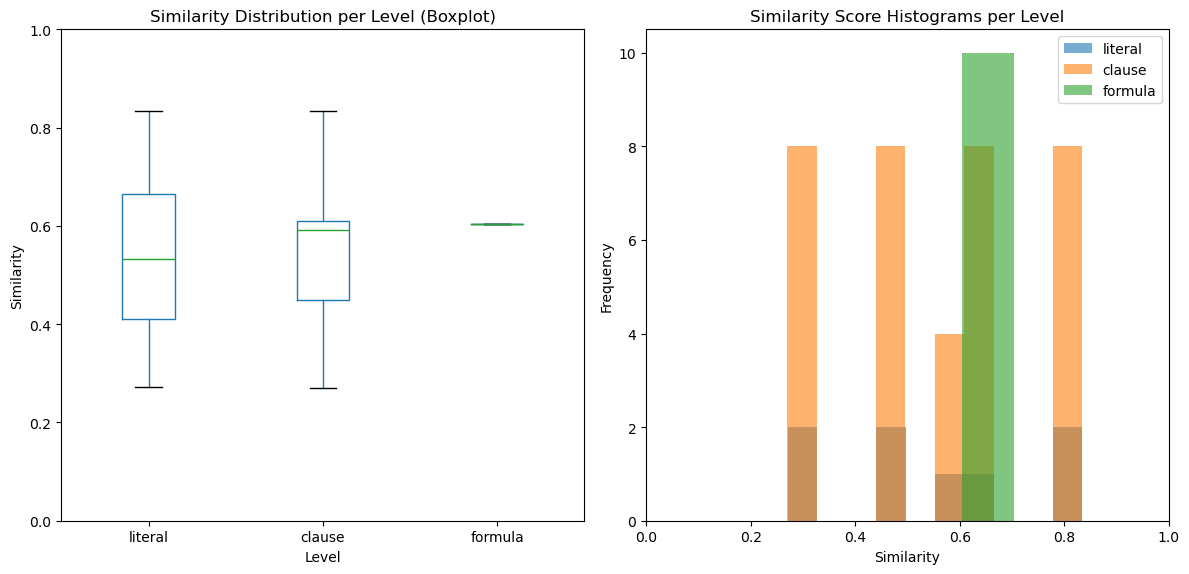

In [18]:
# --- Données pondérées pour I_SA ---
weighted_T1 = {
    "instances": frozenset({
        frozenset({("Teasing", ("Dog", "Monkey"))}),
        frozenset({("AtLocation", ("Dog", "Zoo"))}),
        frozenset({("AtLocation", ("Monkey", "Zoo"))}),
    }),
    "predicate_weights": {
        "Teasing": 0.3,
        "AtLocation": 0.2,
    },
    "constant_weights": {
        "Dog": 0.2,
        "Monkey": 0.2,
        "Zoo": 0.1
    }
}

# --- Données pondérées pour I_SB ---
weighted_T2 = {
    "instances": frozenset({
        frozenset({("Teasing", ("Monkey", "Dog"))}),
        frozenset({("AtLocation", ("Dog", "Zoo"))}),
        frozenset({("AtLocation", ("Monkey", "Zoo"))}),
    }),
    "predicate_weights": {
        "Teasing": 0.3,
        "AtLocation": 0.2,
    },
    "constant_weights": {
        "Dog": 0.2,
        "Monkey": 0.2,
        "Zoo": 0.1
    }
}


###################

weighted_T1eq = {
    "instances": frozenset({
        frozenset({("Teasing", ("Dog", "Monkey"))}),
        frozenset({("AtLocation", ("Dog", "Zoo"))}),
        frozenset({("AtLocation", ("Monkey", "Zoo"))}),
    }),
    "predicate_weights": {
        "Teasing": 0.2,
        "AtLocation": 0.2,
    },
    "constant_weights": {
        "Dog": 0.2,
        "Monkey": 0.2,
        "Zoo": 0.2
    }
}

# --- Données pondérées pour I_SB ---
weighted_T2eq = {
    "instances": frozenset({
        frozenset({("Teasing", ("Monkey", "Dog"))}),
        frozenset({("AtLocation", ("Dog", "Zoo"))}),
        frozenset({("AtLocation", ("Monkey", "Zoo"))}),
    }),
    "predicate_weights": {
        "Teasing": 0.2,
        "AtLocation": 0.2,
    },
    "constant_weights": {
        "Dog": 0.2,
        "Monkey": 0.2,
        "Zoo": 0.2
    }
}

###################

# --- Paramètres de similarité configurables par niveau ---
params = {
    "literal": {
        "w_pred": 0.5,       # pondération du prédicat (si utilisé à terme)
        "w_args": 0.5        # pondération des arguments (idem)
    },
    "clause": {
        "alpha": 0.5,         
        "beta": 0.5,          
        "p": 1,
        "agg": agg_softmax           
    },
    "set": {
        "alpha": 0.5,       
        "beta": 0.5,          
        "p": 1,
        "agg": agg_max      
    }
}

# --- Niveaux de debug à activer ---
debug_flags = {
    "literal": True,
    "clause": True,
    "formula": True
}

# --- Calcul de la similarité avec résumé ---
score, summary = simFormulaSet(
    weighted_T1["instances"],
    weighted_T2["instances"],
    weighted_T1["predicate_weights"],
    weighted_T2["predicate_weights"],
    weighted_T1["constant_weights"],
    weighted_T2["constant_weights"],
    params=params,
    debug=debug_flags
)

print(f"\n🔷 FINAL SIMILARITY SCORE: {score:.3f}")

summarize_debug_output(summary, debug=debug_flags)
summarize_debug_statistics(summary)
summarize_explanation(summary, params)
plot_similarity_distribution(summary)


In [10]:
from sentence_transformers import SentenceTransformer, util

# Charger un modèle SBERT pré-entraîné
model = SentenceTransformer('all-mpnet-base-v2')  # rapide et performant 

T1 = "A dog is teasing a monkey at the zoo"
T2 = "A monkey is teasing a dog at the zoo"

# Encoder les phrases en vecteurs
embedding1 = model.encode(T1, convert_to_tensor=True)
embedding2 = model.encode(T2, convert_to_tensor=True)

# Calculer la similarité cosinus
similarity_score = util.pytorch_cos_sim(embedding1, embedding2)

# Affichage
print(f"Similarity between \"{T1}\" and \"{T2}\": {similarity_score.item():.3f}")

Similarity between "A dog is teasing a monkey at the zoo" and "A monkey is teasing a dog at the zoo": 0.983


T1: A dog is teasing a monkey at the zoo

T2: A monkey is teasing a dog at the zoo
 
TverskyFOL-SBERT: 0.606

TverskyFOL-SBERT_eq: 0.521

SBERT = 0.983

S3BERT = 0.99

Human = 0.63

ChatGPT-o4: I will give you two sentences, return their similarity between 0 and 1. => 0.4
ChatGPT-o4: I will give you two sentences, return the logical similarity between 0 and 1. => 0.4

0.0

🔷 FINAL SIMILARITY SCORE: 0.739

🔍 SUMMARY OF SIMILARITY COMPARISON

📌 LITERAL LEVEL
  → Total literal pairs compared: 71
    - ('Illegal', ('Buy(Bob, Alcohol)',)) ⇄ ('Buy', ('Bob', 'WineBottle'))
      • predicate similarity: 0.2763614058494568
      • argument similarity : 0.0
      • literal similarity   : 0.276
    - ('Allowed', ('Buy(Bob, Alcohol)',)) ⇄ ('Buy', ('Bob', 'WineBottle'))
      • predicate similarity: 0.3186724781990051
      • argument similarity : 0.0
      • literal similarity   : 0.319
    - ('Illegal', ('Buy(Bob, Alcohol)',)) ⇄ ('Allowed', ('Buy(Bob, WineBottle)',))
      • predicate similarity: 0.38631153106689453
      • argument similarity : 0.0
      • literal similarity   : 0.386
    - ('Illegal', ('Buy(Bob, Alcohol)',)) ⇄ ('Illegal', ('Buy(Bob, WineBottle)',))
      • predicate similarity: 1.0
      • argument similarity : 0.0
      • literal similarity   : 1.000
    - ('Allowed', ('Buy(Bob, Alcohol)',)) ⇄ ('Allowed', ('Buy(Bob, WineBottle)',))
      • 

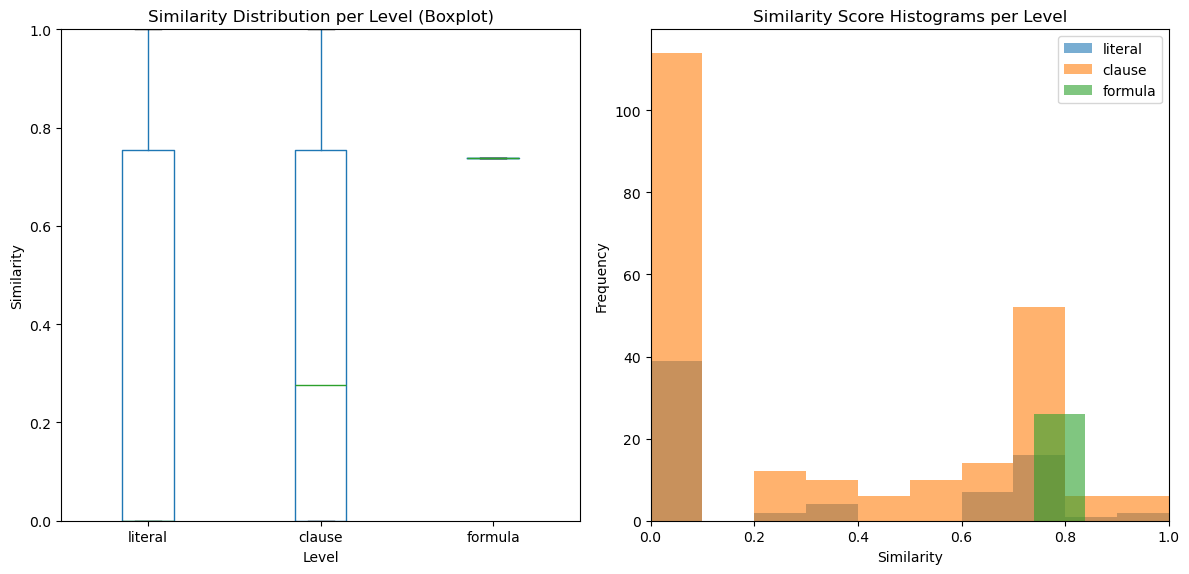

In [21]:
weighted_T1 = {
    "instances": frozenset({
        
            frozenset({("¬Teenager", ("Bob",)), ("¬LivesIn", ("Bob", "France")), ("¬Buy", ("Bob", "Alcohol")), ("¬Allowed", ("Buy(Bob, Alcohol)",))}),
            frozenset({("Allowed", ("Buy(Bob, Alcohol)",)), ("Illegal", ("Buy(Bob, Alcohol)",))}),
            frozenset({("Buy", ("Bob", "Alcohol"))}),
            frozenset({("Illegal", ("Buy(Bob, Alcohol)",))}),
            frozenset({("¬ShouldGoToJailFor", ("Bob", "Buy(Bob, Alcohol)"))}),
        }),
    "predicate_weights": {
        "Teenager": 0.05,
        "LivesIn": 0.05,
        "Buy": 0.15,
        "Allowed": 0.15,
        "Illegal": 0.15,
        "ShouldGoToJailFor": 0.25
    },
    "constant_weights": {
        "Bob": 0.1,
        "France": 0.05,
        "Alcohol": 0.05
    }
}


weighted_T3 = {
    "instances": frozenset({
        
            frozenset({("¬Teenager", ("Bob",)), ("¬LivesIn", ("Bob", "France")), ("¬Buy", ("Bob", "WineBottle")), ("¬Allowed", ("Buy(Bob, WineBottle)",))}),
            frozenset({("Allowed", ("Buy(Bob, WineBottle)",)), ("Illegal", ("Buy(Bob, WineBottle)",))}),
            frozenset({("Buy", ("Bob", "WineBottle"))}),
            frozenset({("¬Severe", ("Buy(Bob, WineBottle)",)), ("¬ShouldGoToJailFor", ("Bob", "Buy(Bob, WineBottle)"))}),
            frozenset({("¬ShouldGoToJailFor", ("Bob", "Buy(Bob, WineBottle)"))}),
        }),
    "predicate_weights": {
        "Teenager": 0.05,
        "LivesIn": 0.05,
        "Buy": 0.15,
        "Allowed": 0.15,
        "Illegal": 0.10,
        "Severe": 0.05,
        "ShouldGoToJailFor": 0.25
    },
    "constant_weights": {
        "Bob": 0.1,
        "France": 0.05,
        "WineBottle": 0.05
    }
}

# --- Niveaux de debug à activer ---
debug_flags = {
    "literal": True,
    "clause": True,
    "formula": True,
    
}

# PARAMS OPTIMISÉ POUR L’ADAPTATIVITÉ DES SIMILARITÉS
"""
params = {
    "literal": {
        "w_pred": 0.5,       # pondération du prédicat (si utilisé à terme)
        "w_args": 0.5        # pondération des arguments (idem)
    },
    "clause": {
        "alpha": 0.25,         
        "beta": 0.25,          
        "p": 3,
        "agg": agg_softmax              
    },
    "formula": {
        "alpha": 0.7,       
        "beta": 0.7,          
        "p": 1,
        "agg": agg_max      
    }
}
"""

params = {
    "literal": {
        "w_pred": 0.5,       # pondération du prédicat (si utilisé à terme)
        "w_args": 0.5        # pondération des arguments (idem)
    },
    "clause": {
        "alpha": 0.5,         
        "beta": 0.5,          
        "p": 1,
        "agg": agg_softmax              
    },
    "formula": {
        "alpha": 0.5,       
        "beta": 0.5,          
        "p": 1,
        "agg": agg_max      
    },
    
}

# --- Calcul de la similarité avec résumé ---
score, summary = simFormulaSet(
    weighted_T1["instances"],
    weighted_T3["instances"],
    weighted_T1["predicate_weights"],
    weighted_T3["predicate_weights"],
    weighted_T1["constant_weights"],
    weighted_T3["constant_weights"],
    params=params,
    debug=debug_flags
)

print(f"\n🔷 FINAL SIMILARITY SCORE: {score:.3f}")
summarize_debug_output(summary, debug=debug_flags)
summarize_debug_statistics(summary)
summarize_explanation(summary, params)
plot_similarity_distribution(summary)

0.0

🔷 FINAL SIMILARITY SCORE: 0.338

🔍 SUMMARY OF SIMILARITY COMPARISON

📌 LITERAL LEVEL
  → Total literal pairs compared: 1
    - ('Posing', ('3Man', 'Tent')) ⇄ ('Eating', ('3Man', 'Kitchen'))
      • predicate similarity: 0.28812724351882935
      • argument similarity : 0.3869258305115196
      • literal similarity   : 0.338

📌 CLAUSE LEVEL
  → Total clause pairs compared: 2
    - Clause 1: ('Posing', ('3Man', 'Tent'))
      Clause 2: ('Eating', ('3Man', 'Kitchen'))
      → Similarity score: 0.338
    - Clause 1: ('Eating', ('3Man', 'Kitchen'))
      Clause 2: ('Posing', ('3Man', 'Tent'))
      → Similarity score: 0.338

📌 FORMULA LEVEL
  → Overall formula similarity:
      a = matched        : 0.338
      b = unmatched src  : 0.662
      c = unmatched tgt  : 0.662
      → Similarity score : 0.338
  → Formula pair compared:
      Formula 1: frozenset({('Posing', ('3Man', 'Tent'))})
      Formula 2: frozenset({('Eating', ('3Man', 'Kitchen'))})
      → Similarity score: 0.338

🔍 STAT

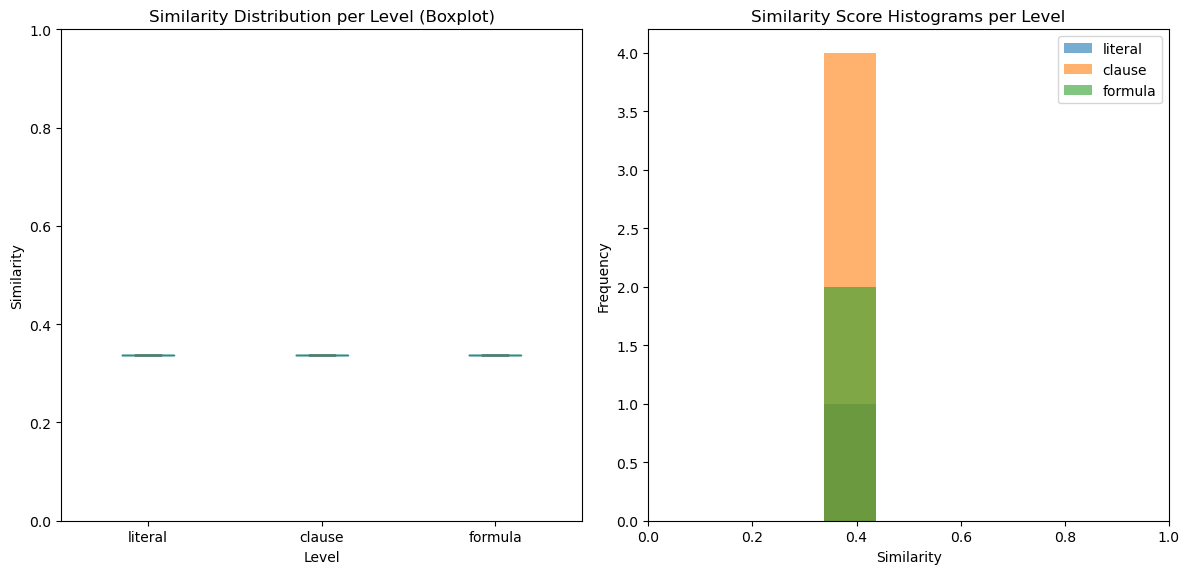

In [22]:
weighted_T1 = {
    "instances": frozenset({
        
            frozenset({("Posing", ("3Man", "Tent"))})
        }),
    "predicate_weights": {
        "Posing": 0.5
    },
    "constant_weights": {
        "3Man": 0.2,
        "Tent": 0.3
    }
}

weighted_T2 = {
    "instances": frozenset({
        
            frozenset({("Eating", ("3Man", "Kitchen"))})
        }),
    "predicate_weights": {
        "Eating": 0.5
    },
    "constant_weights": {
        "3Man": 0.2,
        "Kitchen": 0.3
    }
}

#######################

weighted_T1eq = {
    "instances": frozenset({
        
            frozenset({("Posing", ("3Man", "Tent"))})
        }),
    "predicate_weights": {
        "Posing": 1/3,
        "¬Posing": 0.0,
        "Eating": 0.0,
        "¬Eating": 0.0,
        "In": 0.0,
        "¬In": 0.0
    },
    "constant_weights": {
        "3Man": 1/3,
        "Tent": 1/3,
        "Kitchen": 0.0
    }
}

weighted_T2eq = {
    "instances": frozenset({
        
            frozenset({("Eating", ("3Man", "Kitchen"))})
        }),
    "predicate_weights": {
        "Posing": 0.0,
        "¬Posing": 0.0,
        "Eating": 1/3,
        "¬Eating": 0.0,
        "In": 0.0,
        "¬In": 0.0
    },
    "constant_weights": {
        "3Man": 1/3,
        "Tent": 0.0,
        "Kitchen": 1/3
    }
}

#######################

# --- Paramètres de similarité configurables par niveau ---
params = {
    "literal": {
        "w_pred": 0.5,       # pondération du prédicat (si utilisé à terme)
        "w_args": 0.5        # pondération des arguments (idem)
    },
    "clause": {
        "alpha": 0.5,         
        "beta": 0.5,          
        "p": 1,
        "agg": agg_softmax              
    },
    "formula": {
        "alpha": 0.5,       
        "beta": 0.5,          
        "p": 1,
        "agg": agg_max      
    },
    
}

# --- Niveaux de debug à activer ---
debug_flags = {
    "literal": True,
    "clause": True,
    "formula": True,
    
}

# --- Calcul de la similarité avec résumé ---
score, summary = simFormulaSet(
    weighted_T1["instances"],
    weighted_T2["instances"],
    weighted_T1["predicate_weights"],
    weighted_T2["predicate_weights"],
    weighted_T1["constant_weights"],
    weighted_T2["constant_weights"],
    params=params,
    debug=debug_flags
)
#score, summary = simFormulaSet(weighted_T1, weighted_T2, params=params, debug=debug_flags)

print(f"\n🔷 FINAL SIMILARITY SCORE: {score:.3f}")
summarize_debug_output(summary, debug=debug_flags)
summarize_debug_statistics(summary)
summarize_explanation(summary, params)
plot_similarity_distribution(summary)

In [41]:
from sentence_transformers import SentenceTransformer, util

# Charger un modèle SBERT pré-entraîné
model = SentenceTransformer('all-mpnet-base-v2')  # rapide et performant 

T1 = "three men posing in a tent"
T2 = "three men eating in a kitchen"

# Encoder les phrases en vecteurs
embedding1 = model.encode(T1, convert_to_tensor=True)
embedding2 = model.encode(T2, convert_to_tensor=True)

# Calculer la similarité cosinus
similarity_score = util.pytorch_cos_sim(embedding1, embedding2)

# Affichage
print(f"Similarity between \"{T1}\" and \"{T2}\": {similarity_score.item():.3f}")

Similarity between "three men posing in a tent" and "three men eating in a kitchen": 0.384


T1: three men posing in a tent

T2: three men eating in a kitchen
 
TverskyFOL-SBERT: 0.362

TverskyFOL-SBERT_eq: 0.405

SBERT = 0.384

S3BERT = 0.42

Human = 0.24

ChatGPT-o4: I will give you two sentences, return their similarity between 0 and 1. => 0.25
ChatGPT-o4: I will give you two sentences, return the logical similarity between 0 and 1. => 0.25


🔷 FINAL SIMILARITY SCORE: 0.625

🔍 SUMMARY OF SIMILARITY COMPARISON

📌 LITERAL LEVEL
  → Total literal pairs compared: 4
    - ('PullingUp', ('Jeep',)) ⇄ ('¬PullingUp', ('Jeep',))
      • predicate similarity: 0.3291075825691223
      • argument similarity : 0.7562500901520253
      • literal similarity   : 0.388
    - ('PullingUp', ('Jeep',)) ⇄ ('Walking', ('Child', 'Street'))
      • predicate similarity: 0.25976094603538513
      • argument similarity : 0.20407490506768228
      • literal similarity   : 0.242
    - ('Walking', ('Child', 'Street')) ⇄ ('¬PullingUp', ('Jeep',))
      • predicate similarity: 0.05857771635055542
      • argument similarity : 0.20253776684403418
      • literal similarity   : 0.104
    - ('Walking', ('Child', 'Street')) ⇄ ('Walking', ('Child', 'Street'))
      • predicate similarity: 1.0
      • argument similarity : 0.7611607469511885
      • literal similarity   : 0.862

📌 CLAUSE LEVEL
  → Total clause pairs compared: 8
    - Clause 1: ('PullingUp', ('

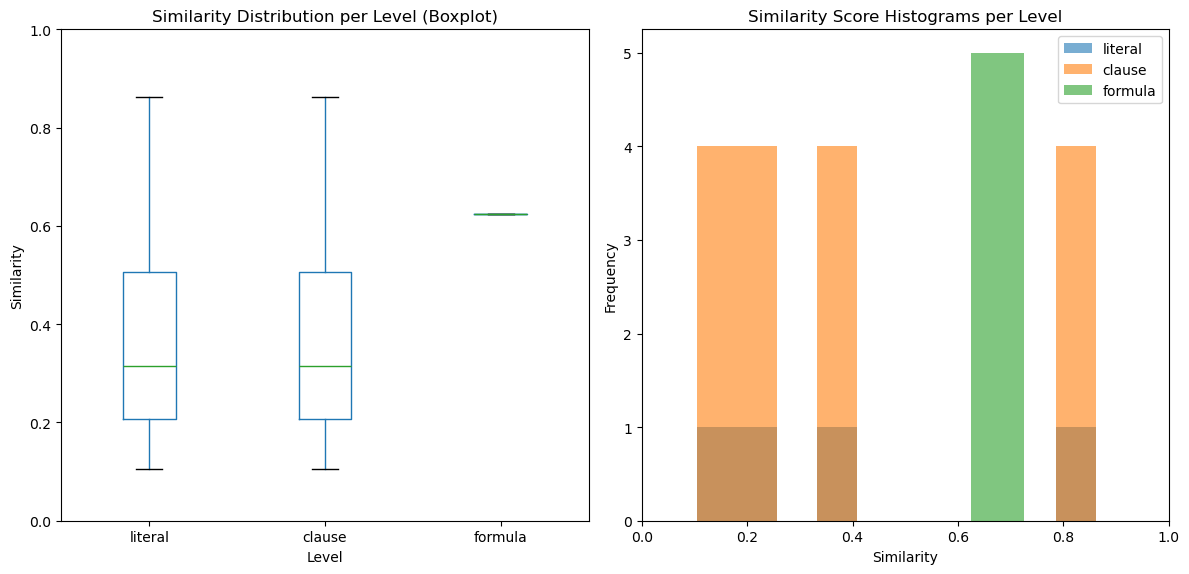

In [106]:

weighted_T1 = {
    "instances": frozenset({
        frozenset({("Walking", ("Child", "Street"))}),
        frozenset({("PullingUp", ("Jeep",))})}),
    "predicate_weights": {
        "Walking": 0.30,
        "PullingUp": 0.25
    },
    "constant_weights": {
        "Child": 0.20,
        "Street": 0.15,
        "Jeep": 0.10
    }
}

weighted_T2  = {
    "instances": frozenset({
        frozenset({("Walking", ("Child", "Street"))}),
        frozenset({("¬PullingUp", ("Jeep",))})}),
    "predicate_weights": {
        "Walking": 0.30,
        "¬PullingUp": 0.25
    },
    "constant_weights": {
        "Child": 0.20,
        "Street": 0.15,
        "Jeep": 0.10
    }
}

"""
weighted_T1eq  = {
    "instances": frozenset({
        ("Walking", ("Child", "Street"))}),
        frozenset({("PullingUp", ("Jeep",))}),
    "predicate_weights": {
        "Walking": 0.2,
        "PullingUp": 0.2
    },
    "constant_weights": {
        "Child": 0.2,
        "Street": 0.2,
        "Jeep": 0.2
    }
}

weighted_T2eq  = {
    "instances": frozenset({
        ("Walking", ("Child", "Street"))}),
        frozenset({("¬PullingUp", ("Jeep",))}),
    "predicate_weights": {
        "Walking": 0.2,
        "PullingUp": 0.2
    },
    "constant_weights": {
        "Child": 0.2,
        "Street": 0.2,
        "Jeep": 0.2
    }
}
"""

"""
params = {
    "literal": {
        "w_pred": 0.5,       # pondération du prédicat (si utilisé à terme)
        "w_args": 0.5        # pondération des arguments (idem)
    },
    "clause": {
        "alpha": 0.25,         
        "beta": 0.25,          
        "p": 3,
        "agg": agg_softmax              
    },
    "formula": {
        "alpha": 0.7,       
        "beta": 0.7,          
        "p": 1,
        "agg": agg_max      
    }
}
"""

params = {
    "literal": {
        "w_pred": 0.5,       # pondération du prédicat (si utilisé à terme)
        "w_args": 0.5        # pondération des arguments (idem)
    },
    "clause": {
        "alpha": 0.5,         
        "beta": 0.5,          
        "p": 1,
        "agg": agg_softmax              
    },
    "formula": {
        "alpha": 0.5,       
        "beta": 0.5,          
        "p": 1,
        "agg": agg_max      
    },
    
}

# --- Niveaux de debug à activer ---
debug_flags = {
    "literal": True,
    "clause": True,
    "formula": True,
    
}

# --- Calcul de la similarité avec résumé ---
score, summary = simFormulaSet(
    weighted_T1["instances"],
    weighted_T2["instances"],
    weighted_T1["predicate_weights"],
    weighted_T2["predicate_weights"],
    weighted_T1["constant_weights"],
    weighted_T2["constant_weights"],
    params=params,
    debug=debug_flags
)

print(f"\n🔷 FINAL SIMILARITY SCORE: {score:.3f}")
summarize_debug_output(summary, debug=debug_flags)

summarize_debug_statistics(summary)
summarize_explanation(summary, params)
plot_similarity_distribution(summary)

In [40]:
from sentence_transformers import SentenceTransformer, util

# Charger un modèle SBERT pré-entraîné
model = SentenceTransformer('all-mpnet-base-v2')  # rapide et performant 

T1 = "A child is walking down the street and a jeep is pulling up"
T2 = "A child is walking down the street and a jeep is not pulling up"

# Encoder les phrases en vecteurs
embedding1 = model.encode(T1, convert_to_tensor=True)
embedding2 = model.encode(T2, convert_to_tensor=True)

# Calculer la similarité cosinus
similarity_score = util.pytorch_cos_sim(embedding1, embedding2)

# Affichage
print(f"Similarity between \"{T1}\" and \"{T2}\": {similarity_score.item():.3f}")

Similarity between "A child is walking down the street and a jeep is pulling up" and "A child is walking down the street and a jeep is not pulling up": 0.927


T1: A child is walking down the street and a jeep is pulling up

T2: A child is walking down the street and a jeep is not pulling up
 
TverskyFOL-SBERT: 0.668

TverskyFOL-SBERT_eq: 0.628

SBERT = 0.927

S3BERT = 0.92

Human = 0.63

ChatGPT-o4: I will give you two sentences, return their similarity between 0 and 1. => 0.5
ChatGPT-o4: I will give you two sentences, return the logical similarity between 0 and 1. => 0.45

0.0

🔷 FINAL SIMILARITY SCORE: 0.633

🔍 SUMMARY OF SIMILARITY COMPARISON

📌 LITERAL LEVEL
  → Total literal pairs compared: 2
    - ('Running', ('Rocky', 'Beach')) ⇄ ('Running', ('Men', 'Beach'))
      • predicate similarity: 1.0
      • argument similarity : 0.3957323022186756
      • literal similarity   : 0.637
    - ('Running', ('ApolloCreed', 'Beach')) ⇄ ('Running', ('Men', 'Beach'))
      • predicate similarity: 1.0
      • argument similarity : 0.3763259027153253
      • literal similarity   : 0.626

📌 CLAUSE LEVEL
  → Total clause pairs compared: 4
    - Clause 1: ('Running', ('Rocky', 'Beach'))
      Clause 2: ('Running', ('Men', 'Beach'))
      → Similarity score: 0.637
    - Clause 1: ('Running', ('ApolloCreed', 'Beach'))
      Clause 2: ('Running', ('Men', 'Beach'))
      → Similarity score: 0.626
    - Clause 1: ('Running', ('Men', 'Beach'))
      Clause 2: ('Running', ('Rocky', 'Beach'))
      → Similarity score: 0.636
    - Clause 1: ('Running', ('Men', 'Beach'))
      C

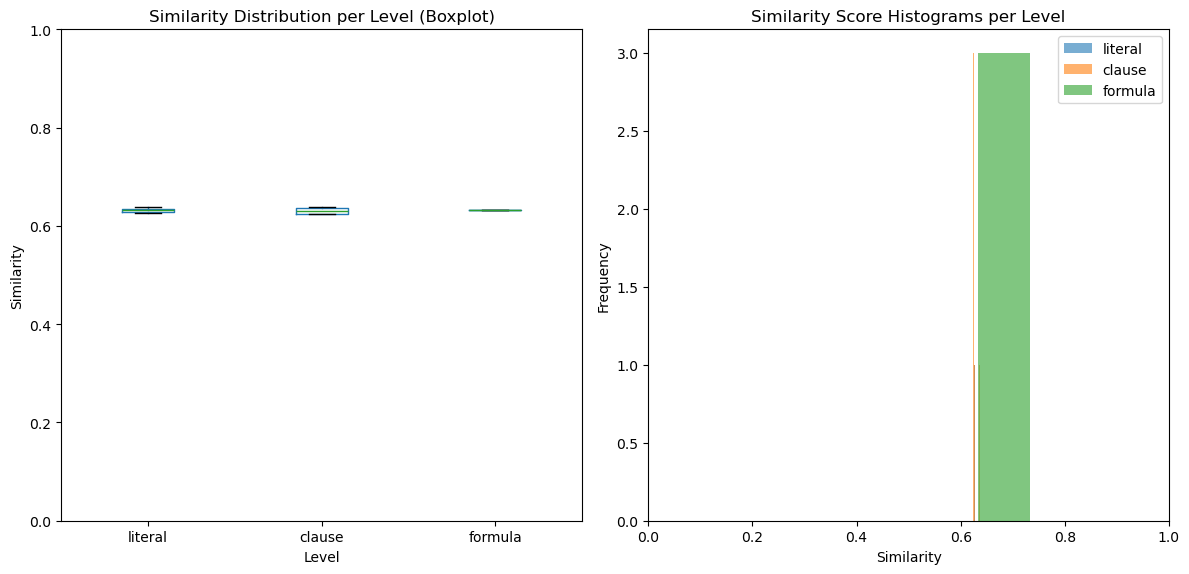

In [128]:
weighted_T1 = {
    "instances": frozenset({
        
            frozenset({("Running", ("Rocky", "Beach"))}),
            frozenset({("Running", ("ApolloCreed", "Beach"))})
        }),
    "predicate_weights": {
        "Running": 0.4
    },
    "constant_weights": {
        "Rocky": 0.2,
        "ApolloCreed": 0.2,
        "Beach": 0.2
    }
}

weighted_T2 = {
    "instances": frozenset({
        
            frozenset({("Running", ("Men", "Beach"))})
        }),
    "predicate_weights": {
        "Running": 0.4
    },
    "constant_weights": {
        "Men": 0.4,
        "Beach": 0.2
    }
}

#######################

weighted_T1eq = {
    "instances": frozenset({
        
            frozenset({("Running", ("Rocky", "Beach"))}),
            frozenset({("Running", ("ApolloCreed", "Beach"))})
        }),
    "predicate_weights": {
        "Running": 0.25
    },
    "constant_weights": {
        "Rocky": 0.25,
        "ApolloCreed": 0.25,
        "Beach": 0.25
    }
}

weighted_T2eq = {
    "instances": frozenset({
        
            frozenset({("Running", ("Men", "Beach"))})
        }),
    "predicate_weights": {
        "Running": 1/3
    },
    "constant_weights": {
        "Men": 1/3,
        "Beach": 1/3
    }
}

#######################

params = {
    "literal": {
        "w_pred": 0.5,       # pondération du prédicat (si utilisé à terme)
        "w_args": 0.5        # pondération des arguments (idem)
    },
    "clause": {
        "alpha": 0.5,         
        "beta": 0.5,          
        "p": 1,
        "agg": agg_softmax              
    },
    "formula": {
        "alpha": 0.5,       
        "beta": 0.5,          
        "p": 1,
        "agg": agg_max      
    },
    
}

# --- Niveaux de debug à activer ---
debug_flags = {
    "literal": True,
    "clause": True,
    "formula": True
    
}

# --- Calcul de la similarité avec résumé ---
score, summary = simFormulaSet(
    weighted_T1["instances"],
    weighted_T2["instances"],
    weighted_T1["predicate_weights"],
    weighted_T2["predicate_weights"],
    weighted_T1["constant_weights"],
    weighted_T2["constant_weights"],
    params=params,
    debug=debug_flags
)
#score, summary = simFormulaSet(weighted_T1eq, weighted_T2eq, params=params, debug=debug_flags)

print(f"\n🔷 FINAL SIMILARITY SCORE: {score:.3f}")
summarize_debug_output(summary, debug=debug_flags)

summarize_debug_statistics(summary)
summarize_explanation(summary, params)
plot_similarity_distribution(summary)

In [39]:
from sentence_transformers import SentenceTransformer, util

# Charger un modèle SBERT pré-entraîné
model = SentenceTransformer('all-mpnet-base-v2')  # rapide et performant 

T1 = "rocky and apollo creed are running down the beach"
T2 = "the men are jogging on the beach"

# Encoder les phrases en vecteurs
embedding1 = model.encode(T1, convert_to_tensor=True)
embedding2 = model.encode(T2, convert_to_tensor=True)

# Calculer la similarité cosinus
similarity_score = util.pytorch_cos_sim(embedding1, embedding2)

# Affichage
print(f"Similarity between \"{T1}\" and \"{T2}\": {similarity_score.item():.3f}")

Similarity between "rocky and apollo creed are running down the beach" and "the men are jogging on the beach": 0.443


T1: rocky and apollo creed are running down the beach

T2: the men are jogging on the beach
 
TverskyFOL-SBERT: 0.694

TverskyFOL-SBERT_eq: 0.593

SBERT = 0.443

S3BERT = 0.32

Human = 0.6

ChatGPT-o4: I will give you two sentences, return their similarity between 0 and 1. => 0.8
ChatGPT-o4: I will give you two sentences, return the logical similarity between 0 and 1. => 0.7

1.2000000000000002

🔷 FINAL SIMILARITY SCORE: 0.019

🔍 SUMMARY OF SIMILARITY COMPARISON

📌 LITERAL LEVEL
  → Total literal pairs compared: 1
    - ('Smoking', ('Man',)) ⇄ ('Sucking', ('Baby', 'Pacifier'))
      • predicate similarity: 0.4578295052051544
      • argument similarity : 0.014343316555023196
      • literal similarity   : 0.019

📌 CLAUSE LEVEL
  → Total clause pairs compared: 2
    - Clause 1: ('Smoking', ('Man',))
      Clause 2: ('Sucking', ('Baby', 'Pacifier'))
      → Similarity score: 0.019
    - Clause 1: ('Sucking', ('Baby', 'Pacifier'))
      Clause 2: ('Smoking', ('Man',))
      → Similarity score: 0.019

📌 FORMULA LEVEL
  → Overall formula similarity:
      a = matched        : 0.019
      b = unmatched src  : 0.981
      c = unmatched tgt  : 0.981
      → Similarity score : 0.019
  → Formula pair compared:
      Formula 1: frozenset({('Smoking', ('Man',))})
      Formula 2: frozenset({('Sucking', ('Baby', 'Pacifier'))})
      → Similarity score: 0.019

🔍 STATISTI

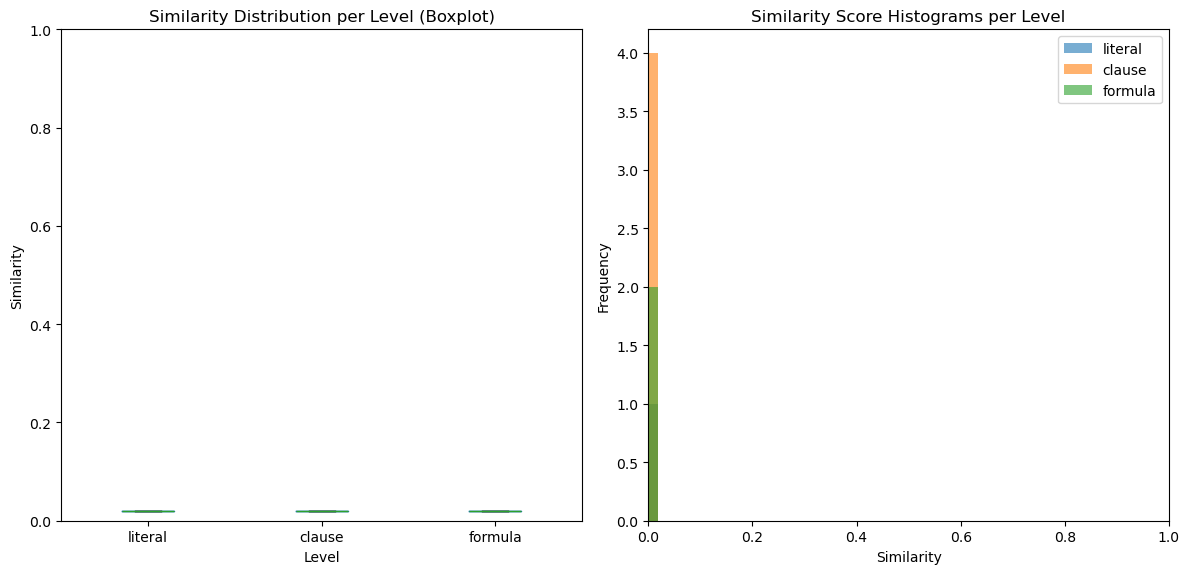

In [23]:
weighted_T1 = {
    "instances": frozenset({
        
            frozenset({("Smoking", ("Man",))})
        }),
    "predicate_weights": {
        "Smoking": 0.2
    },
    "constant_weights": {
        "Man": 0.2
    }
}

weighted_T2 = {
    "instances": frozenset({
        
            frozenset({("Sucking", ("Baby", "Pacifier"))})
        }),
    "predicate_weights": {
        "Sucking": 0.2
    },
    "constant_weights": {
        "Baby": 0.2,
        "Pacifier": 0.0
    }
}


#########################

weighted_T1eq = {
    "instances": frozenset({
        
            frozenset({("Smoking", ("Man",))})
        }),
    "predicate_weights": {
        "Smoking": 0.50
    },
    "constant_weights": {
        "Man": 0.50
    }
}

weighted_T2eq = {
    "instances": frozenset({
        
            frozenset({("Sucking", ("Baby", "Pacifier"))})
        }),
    "predicate_weights": {
        "Sucking": 1/3
    },
    "constant_weights": {
        "Baby": 1/3,
        "Pacifier": 1/3
    }
}

#########################


params = {
    "literal": {
        "w_pred": 0.5,       # pondération du prédicat (si utilisé à terme)
        "w_args": 0.5        # pondération des arguments (idem)
    },
    "clause": {
        "alpha": 0.5,         
        "beta": 0.5,          
        "p": 1,
        "agg": agg_softmax              
    },
    "formula": {
        "alpha": 0.5,       
        "beta": 0.5,          
        "p": 1,
        "agg": agg_max      
    },
    
}

# --- Niveaux de debug à activer ---
debug_flags = {
    "literal": True,
    "clause": True,
    "formula": True
    
}

# --- Calcul de la similarité avec résumé ---
#score, summary = simFormulaSet(weighted_T1eq, weighted_T2eq, params=params, debug=debug_flags)
score, summary = simFormulaSet(
    weighted_T1["instances"],
    weighted_T2["instances"],
    weighted_T1["predicate_weights"],
    weighted_T2["predicate_weights"],
    weighted_T1["constant_weights"],
    weighted_T2["constant_weights"],
    params=params,
    debug=debug_flags
)

print(f"\n🔷 FINAL SIMILARITY SCORE: {score:.3f}")
summarize_debug_output(summary, debug=debug_flags)

summarize_debug_statistics(summary)
summarize_explanation(summary, params)
plot_similarity_distribution(summary)

In [42]:
from sentence_transformers import SentenceTransformer, util

# Charger un modèle SBERT pré-entraîné
model = SentenceTransformer('all-mpnet-base-v2')  # rapide et performant 

T1 = "a man is smoking"
T2 = "a baby is sucking on a pacifier"

# Encoder les phrases en vecteurs
embedding1 = model.encode(T1, convert_to_tensor=True)
embedding2 = model.encode(T2, convert_to_tensor=True)

# Calculer la similarité cosinus
similarity_score = util.pytorch_cos_sim(embedding1, embedding2)

# Affichage
print(f"Similarity between \"{T1}\" and \"{T2}\": {similarity_score.item():.3f}")

Similarity between "a man is smoking" and "a baby is sucking on a pacifier": 0.070


T1: a man is smoking

T2: a baby is sucking on a pacifier
 
TverskyFOL-SBERT: 0.050

TverskyFOL-SBERT_eq: 0.048

SBERT = 0.070

S3BERT = 0.06

Human = 0

ChatGPT-o4: I will give you two sentences, return their similarity between 0 and 1. => 0.15
ChatGPT-o4: I will give you two sentences, return the logical similarity between 0 and 1. => 0.1

In [ ]:

from typing import Any, Dict, List, Tuple

def simSetClauseSet_combined_with_summary(
    wI1: Dict[str, Any],
    wI2: Dict[str, Any],
    params: dict = None,
    debug: dict = None
) -> Tuple[float, Dict[str, List[Any]]]:
    for level in _seen_debugs:
        _seen_debugs[level].clear()
    for level in _debug_summary:
        _debug_summary[level].clear()

    set1 = wI1["instances"]
    set2 = wI2["instances"]
    pw1 = wI1["predicate_weights"]
    pw2 = wI2["predicate_weights"]
    cw1 = wI1["constant_weights"]
    cw2 = wI2["constant_weights"]

    alpha = params.get("set", {}).get("alpha", 1.0)
    beta = params.get("set", {}).get("beta", 1.0)
    p = params.get("set", {}).get("p", 1.0)
    agg = params.get("set", {}).get("agg", max)

    score = generalized_tversky_similarity(
        set1, set2,
        sim=lambda cset1, cset2: generalized_tversky_similarity(
            cset1, cset2,
            sim=lambda l1, l2: simLbert_flexibled_weighted(l1, l2, pw1, pw2, cw1, cw2, debug=debug),
            alpha=params.get("clause", {}).get("alpha", 0.5),
            beta=params.get("clause", {}).get("beta", 0.5),
            p=params.get("clause", {}).get("p", 1.0),
            agg=params.get("clause", {}).get("agg", max),
            debug=debug,
            debug_level="clause"
        ),
        alpha=alpha,
        beta=beta,
        p=p,
        agg=agg,
        debug=debug,
        debug_level="set"
    )
    return score, _debug_summary


In [63]:
#clause1 = frozenset({("Posing", ("3Man", "Tent"))})
#clause2 = frozenset({("Eating", ("3Man", "Kitchen"))})

#predicate_weights1 = {"Posing": 0.5}
#predicate_weights2 = {"Eating": 0.5}
#constant_weights1 = {"3Man": 0.2, "Tent": 0.3}
#constant_weights2 = {"3Man": 0.2, "Kitchen": 0.3}

#clause1 = frozenset({("PullingUp", ("Jeep",))})
#clause2 = frozenset({("¬PullingUp", ("Jeep",))})

#predicate_weights1 = {"PullingUp": 0.25}
#predicate_weights2 = {"¬PullingUp": 0.25}
#constant_weights1 = {"Jeep": 0.1}
#constant_weights2 = {"Jeep": 0.1}

clause1 = frozenset({("Smoking", ("Man",))})
clause2 = frozenset({("Sucking", ("Baby","Pacifier"))})

predicate_weights1 = {"Smoking": 0.15}
predicate_weights2 = {"Sucking": 0.15}
constant_weights1 = {"Man": 0.1}
constant_weights2 = {"Baby": 0.1, "Pacifier": 0}

# Version ultra-détaillée de detailed_clause_similarity_debug avec traçage complet de chaque étape

def detailed_clause_similarity_debug_verbose(
   clause1: FrozenSet[Tuple[str, Tuple[str, ...]]],
    clause2: FrozenSet[Tuple[str, Tuple[str, ...]]],
    predicate_weights1: Dict[str, float],
    predicate_weights2: Dict[str, float],
    constant_weights1: Dict[str, float],
    constant_weights2: Dict[str, float],
    alpha: float = 0.5,
    beta: float = 0.5,
    p: float = 1.0,
    agg: Callable[[List[float]], float] = agg_avg
) -> float:
    print("\n🔍 Detailed clause similarity analysis (verbose)\n")

    predicate_weights = {**predicate_weights1, **predicate_weights2}
    constant_weights = {**constant_weights1, **constant_weights2}

    def sim_literal_with_trace(l1, l2):
        pred1, args1 = l1
        pred2, args2 = l2

        sim_pred = sim_sbert_normalized(pred1, pred2)
        w_pred1 = predicate_weights.get(pred1, 0.0)
        w_pred2 = predicate_weights.get(pred2, 0.0)
        imp_pred = w_pred1 * w_pred2

        sim_args = pointwise_similarity_weighted(
            list(args1), list(args2), sim_sbert_normalized,
            weights1=constant_weights,
            weights2=constant_weights
        )

        imp_args = sum(
            constant_weights.get(a1, 0.0) * constant_weights.get(a2, 0.0)
            for a1 in args1 for a2 in args2
        )

        num = sim_pred * imp_pred + sim_args * imp_args
        denom = imp_pred + imp_args

        sum_pred = sum(predicate_weights.values())
        sum_const = sum(constant_weights.values())
        diff = 2 - sum_pred - sum_const
        if diff > 0:
            denom = 1

        score = num / denom if denom > 0 else 0.0

        print(f"Literal 1: {l1}, Literal 2: {l2}")
        print(f"  → Predicate similarity:")
        print(f"      - sim_sbert_normalized('{pred1}', '{pred2}') = {sim_pred:.3f}")
        print(f"      - weights: w1 = {w_pred1:.3f}, w2 = {w_pred2:.3f}")
        print(f"      - imp_pred = {w_pred1:.3f} × {w_pred2:.3f} = {imp_pred:.3f}")
        print(f"      - sim_pred × imp_pred = {sim_pred:.3f} × {imp_pred:.3f} = {sim_pred * imp_pred:.3f}")
        print(f"  → Argument similarity:")
        for a1 in args1:
            for a2 in args2:
                w1 = constant_weights.get(a1, 0.0)
                w2 = constant_weights.get(a2, 0.0)
                sim = sim_sbert_normalized(a1, a2)
                print(f"      - sim('{a1}', '{a2}') = {sim:.3f}, weights: {w1:.3f} × {w2:.3f} = {w1 * w2:.3f}")
        print(f"      - Total imp_args = {imp_args:.3f}")
        print(f"      - sim_args × imp_args = {sim_args:.3f} × {imp_args:.3f} = {sim_args * imp_args:.3f}")
        print(f"  → Final score = ({sim_pred * imp_pred:.3f} + {sim_args * imp_args:.3f}) / ({denom:.3f}) = {score:.3f}\n")

        return score

    X, Y = clause1, clause2

    def membership(x, Y):
        sims = [sim_literal_with_trace(x, y) ** p for y in Y]
        return agg(sims)

    match_X = [membership(x, Y) for x in X]
    match_Y = [membership(y, X) for y in Y]

    a = (sum(match_X) + sum(match_Y)) / 2
    b = sum(1 - s for s in match_X)
    c = sum(1 - s for s in match_Y)

    denom = a + alpha * b + beta * c
    score = a / denom if denom > 0 else 0.0

    print(f"🔹 Aggregated match: a = {a:.3f}")
    print(f"🔹 Unmatched source: b = {b:.3f}")
    print(f"🔹 Unmatched target: c = {c:.3f}")
    print(f"➡️ Clause-level Tversky similarity = {score:.3f}")

    return score
    
detailed_clause_similarity_debug_verbose(
    clause1, clause2,
    predicate_weights1, predicate_weights2,
    constant_weights1, constant_weights2,
    alpha=0.5,
    beta=0.5,
    p=1.0,
    agg=agg_avg
)


🔍 Detailed clause similarity analysis (verbose)

Literal 1: ('Smoking', ('Man',)), Literal 2: ('Sucking', ('Baby', 'Pacifier'))
  → Predicate similarity:
      - sim_sbert_normalized('Smoking', 'Sucking') = 0.458
      - weights: w1 = 0.150, w2 = 0.150
      - imp_pred = 0.150 × 0.150 = 0.022
      - sim_pred × imp_pred = 0.458 × 0.022 = 0.010
  → Argument similarity:
      - sim('Man', 'Baby') = 0.441, weights: 0.100 × 0.100 = 0.010
      - sim('Man', 'Pacifier') = 0.193, weights: 0.100 × 0.000 = 0.000
      - Total imp_args = 0.010
      - sim_args × imp_args = 0.004 × 0.010 = 0.000
  → Final score = (0.010 + 0.000) / (1.000) = 0.010

Literal 1: ('Sucking', ('Baby', 'Pacifier')), Literal 2: ('Smoking', ('Man',))
  → Predicate similarity:
      - sim_sbert_normalized('Sucking', 'Smoking') = 0.458
      - weights: w1 = 0.150, w2 = 0.150
      - imp_pred = 0.150 × 0.150 = 0.022
      - sim_pred × imp_pred = 0.458 × 0.022 = 0.010
  → Argument similarity:
      - sim('Baby', 'Man') = 0.4

0.010337022158503533